<a href="https://colab.research.google.com/github/KimJaeHo2602/Covid-classification/blob/main/covid_GRU%2C_BI_LSTM_Algorithm_dense_Deep%20Layer%20-%3E%20bad%20result_22_10_18_MLP_%ED%95%A9%EC%B9%9C_%EA%B7%B8%EB%9E%98%ED%94%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/NioushaR/LSTM-GRU-BiLSTM-in-TensorFlow-for-predictive-analytics/blob/master/LSTM%26GRU%26BiLSTM.ipynb

In [ ]:
 #13일 데이터가 15만이라 망함의 사본

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
pip install statsmodels

In [ ]:
import os
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'jaehokim123'
os.environ['KAGGLE_KEY'] = '31f0a9e622197f78f754287a7258bf9a'


In [ ]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!rm *.*
!kaggle datasets download -d antgoldbloom/covid19-data-from-john-hopkins-university
!unzip '*.zip'


rm: cannot remove '*.*': No such file or directory
 66% 7.00M/10.6M [00:00<00:00, 70.1MB/s]
100% 10.6M/10.6M [00:00<00:00, 87.2MB/s]
Archive:  covid19-data-from-john-hopkins-university.zip
  inflating: CONVENIENT_global_confirmed_cases.csv  
  inflating: CONVENIENT_global_deaths.csv  
  inflating: CONVENIENT_global_metadata.csv  
  inflating: CONVENIENT_us_confirmed_cases.csv  
  inflating: CONVENIENT_us_deaths.csv  
  inflating: CONVENIENT_us_metadata.csv  
  inflating: RAW_global_confirmed_cases.csv  
  inflating: RAW_global_deaths.csv   
  inflating: RAW_us_confirmed_cases.csv  
  inflating: RAW_us_deaths.csv       


In [ ]:
df_case = pd.read_csv('RAW_global_confirmed_cases.csv')
df_death = pd.read_csv('RAW_global_deaths.csv')

In [ ]:
df_case['Country/Region'].value_counts() #국가가 여러개로 나뉘어져 있는 걸 볼수있다. 나뉘어져 있는걸 결합해야햐한다.

China             34
Canada            16
United Kingdom    15
France            12
Australia          8
                  ..
Guinea             1
Guinea-Bissau      1
Guyana             1
Haiti              1
Zimbabwe           1
Name: Country/Region, Length: 201, dtype: int64

In [ ]:
def fix_dataframe(df):
  # TODO: 불필요한 컬럼 제거, Date를 datetime 객체로 변환, Date를 index로 변경
  df = df.drop(['Lat','Long'],axis=1).groupby('Country/Region').sum()
  #Lat: 지역의 위도 , Long: 지역의 경도를 drop시키고, 을나뉘어져 있는 Country와 Rigion을 결합한다.
  df = df.transpose() # 날짜가 index가 되게한다.
  df.index.name = 'Date' #index 이름을 Date로 설정
  df.reset_index(inplace=True)#인덱스 내용을 수정.
  df['Date'] = df['Date'].apply(lambda s : pd.to_datetime(str(s))) #날짜로 변환
  df.set_index('Date', inplace=True) #set index를 이용하여 date를 index로 바꿔준다
  return df

In [ ]:
df_case = fix_dataframe(df_case)
df_death = fix_dataframe(df_death)

<ipython-input-8-da3ea7b16456>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.drop(['Lat','Long'],axis=1).groupby('Country/Region').sum()
<ipython-input-8-da3ea7b16456>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.drop(['Lat','Long'],axis=1).groupby('Country/Region').sum()


In [ ]:
df_case

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05,209390,334427,271477,47875,105277,11,9106,10044125,446819,11385534,...,1034303,251071,12014,552051,11526966,703228,535,11945,343135,264127
2023-03-06,209406,334427,271477,47875,105277,11,9106,10044957,446819,11385534,...,1034303,251071,12014,552125,11526966,703228,535,11945,343135,264127
2023-03-07,209436,334427,271490,47875,105277,11,9106,10044957,446819,11385534,...,1034303,251071,12014,552157,11526986,703228,535,11945,343135,264127


In [ ]:
df_death

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05,7896,3598,6881,165,1933,0,146,130463,8721,19459,...,7617,1637,14,5854,43186,5708,0,2159,4057,5668
2023-03-06,7896,3598,6881,165,1933,0,146,130472,8721,19459,...,7617,1637,14,5854,43186,5708,0,2159,4057,5668
2023-03-07,7896,3598,6881,165,1933,0,146,130472,8721,19459,...,7617,1637,14,5854,43186,5708,0,2159,4057,5668


In [ ]:
def plot_case_with_death(country):
  plt.plot(df_case.index, df_case[country], 'b-')
  plt.ylabel('Confirmed Cases', color='blue')
  plt.title(country + ' Cases & Deaths')
  plt.xlabel('Date')
  plt.xlim(right=df_case.index[-1])
  plt.ylim(0, df_case[country].max()*1.1)

  ax = plt.gca()
  ax2 = ax.twinx()
  ax2.plot(df_death.index, df_death[country], 'r--')
  ax2.set_ylabel('Deaths', color='red')
  ax2.set_ylim(0, df_death[country].max()*1.3)
  plt.show()

In [ ]:
# 나라별 시간에 따른 확진자 수 및 사망자 수 시각화하기
def plot_case_with_death(country):
  plt.plot(df_case.index, df_case[country],'b-') #def_case를 일단  plot한다. index가 날짜
  plt.ylabel('Confirmed Cases', color='blue') #y축
  plt.title(country+ '  Cases & Deaths') #title
  plt.xlim(right=df_case.index[-1])#xlim : x의 limit를 정해준다. 그래프가 # 오른쪽 끝에 붙는다
  plt.xlabel('Date')
  plt.ylim(0, df_case[country].max()*1.1) #파란색선 발생자 수가 밑에 붙는다.

  ax = plt.gca() #matplotlib 객체에 대한 정보는 plt.gea() 함수로 구할 수 있다.
#gca()로 현재의 Axes를, gcf()로 현재의 Figure 객체를 구할 수 있다. 경우에 따라서 유용하게 사용된다. 이 두 함수는 만약 현재의 Axes나 Figure가 없을 경우 새로 생성한다
  ax2 = ax.twinx() #tiwnx 동일한 x를 공유하면서 서로 다른 y를 가진다. x를 공유하고, y가 2개이다.
  ax2.plot(df_death.index, df_death[country], 'r--')
  ax2.set_ylabel('Deaths', color='red')
  ax2.set_ylim(0, df_death[country].max()*1.3) #빨간색선 사망자수가 밑에 붙는다.
  plt.show()


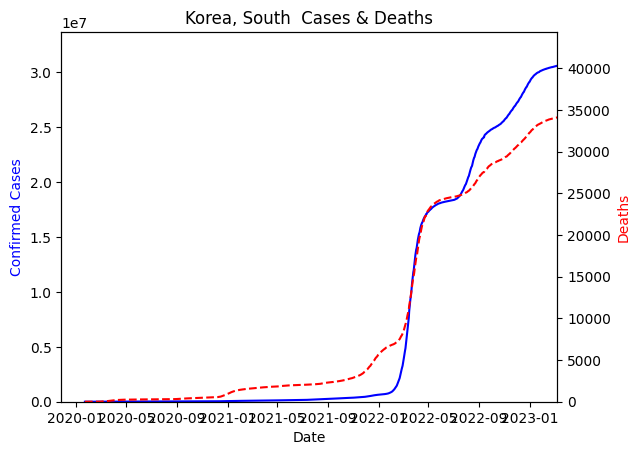

In [ ]:
plot_case_with_death('Korea, South')

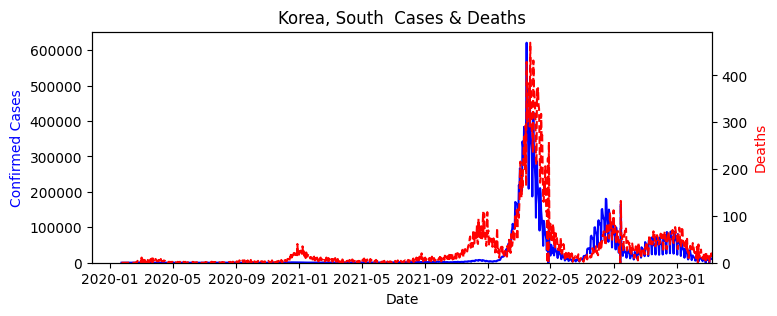

In [ ]:
# 한국의 일일 확진자 수/사망자 수를 시각화하고 분석하시오.
#일일 확진자는 diff만주면된다.
plt.figure(figsize=(8, 3))
country = 'Korea, South'
plt.plot(df_case.index, df_case[country].diff(),'b-') #def_case를 일단  plot한다. index가 날짜, 일일 확진자는 diff만주면된다.
plt.ylabel('Confirmed Cases', color='blue') #y축
plt.title(country+ '  Cases & Deaths') #title
plt.xlim(right=df_case.index[-1])#xlim : x의 limit를 정해준다. 그래프가 # 오른쪽 끝에 붙는다
plt.xlabel('Date')
plt.ylim(bottom = 0) #바닥을 0으로 준다.

ax = plt.gca() #matplotlib 객체에 대한 정보는 plt.gea() 함수로 구할 수 있다.
#gca()로 현재의 Axes를, gcf()로 현재의 Figure 객체를 구할 수 있다. 경우에 따라서 유용하게 사용된다. 이 두 함수는 만약 현재의 Axes나 Figure가 없을 경우 새로 생성한다
ax2 = ax.twinx() #tiwnx 동일한 x를 공유하면서 서로 다른 y를 가진다. x를 공유하고, y가 2개이다.
ax2.plot(df_death.index, df_death[country].diff(), 'r--') #일일 확진자는 diff만주면된다.
ax2.set_ylabel('Deaths', color='red')
ax2.set_ylim(bottom=0) #빨간색선 사망자수가 밑에 붙는다.
plt.show()

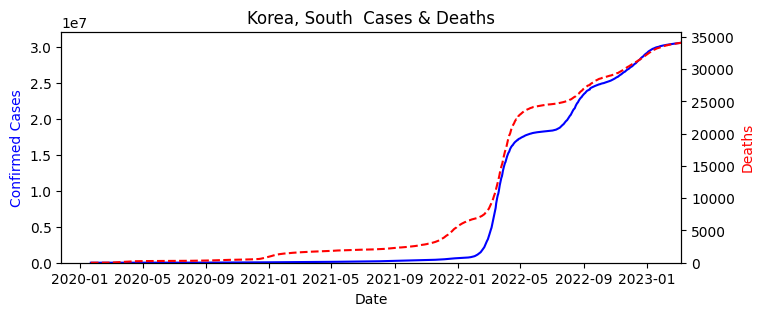

In [ ]:
# 한국의 일일 확진자 수/사망자 수를 시각화하고 분석하시오.
#일일 확진자는 diff만주면된다.
plt.figure(figsize=(8, 3))
country = 'Korea, South'
plt.plot(df_case.index, df_case[country],'b-') #def_case를 일단  plot한다. index가 날짜, 일일 확진자는 diff만주면된다.
plt.ylabel('Confirmed Cases', color='blue') #y축
plt.title(country+ '  Cases & Deaths') #title
plt.xlim(right=df_case.index[-1])#xlim : x의 limit를 정해준다. 그래프가 # 오른쪽 끝에 붙는다
plt.xlabel('Date')
plt.ylim(bottom = 0) #바닥을 0으로 준다.

ax = plt.gca() #matplotlib 객체에 대한 정보는 plt.gea() 함수로 구할 수 있다.
#gca()로 현재의 Axes를, gcf()로 현재의 Figure 객체를 구할 수 있다. 경우에 따라서 유용하게 사용된다. 이 두 함수는 만약 현재의 Axes나 Figure가 없을 경우 새로 생성한다
ax2 = ax.twinx() #tiwnx 동일한 x를 공유하면서 서로 다른 y를 가진다. x를 공유하고, y가 2개이다.
ax2.plot(df_death.index, df_death[country], 'r--') #일일 확진자는 diff만주면된다.
ax2.set_ylabel('Deaths', color='red')
ax2.set_ylim(bottom=0) #빨간색선 사망자수가 밑에 붙는다.
plt.show()

In [ ]:
df = df_case.reset_index()[['Date', 'Korea, South']]

In [ ]:
print(df.dtypes)

Country/Region
Date            datetime64[ns]
Korea, South             int64
dtype: object


In [ ]:
df

Country/Region,Date,"Korea, South"
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3
...,...,...
1138,2023-03-05,30569215
1139,2023-03-06,30581499
1140,2023-03-07,30594297
1141,2023-03-08,30605187


In [ ]:
df.columns=['Date','Count']

In [ ]:
df

,Date,Count
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3
...,...,...
1138,2023-03-05,30569215
1139,2023-03-06,30581499
1140,2023-03-07,30594297
1141,2023-03-08,30605187


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df.dtypes

Count    int64
dtype: object

In [ ]:
df

,Count
Date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,3
...,...
2023-03-05,30569215
2023-03-06,30581499
2023-03-07,30594297


In [ ]:
df['Count'] = df['Count'].astype(float)

In [ ]:
df

,Count
Date,
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,2.0
2020-01-26,3.0
...,...
2023-03-05,30569215.0
2023-03-06,30581499.0
2023-03-07,30594297.0


In [ ]:
df

,Count
Date,
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,2.0
2020-01-26,3.0
...,...
2023-03-05,30569215.0
2023-03-06,30581499.0
2023-03-07,30594297.0


In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

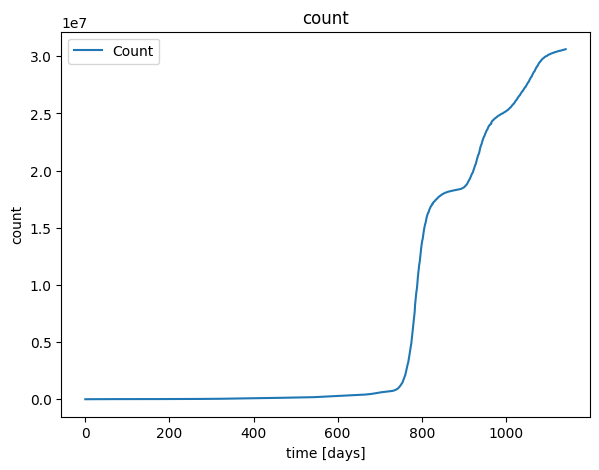

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Count.values, label='Count')
# plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
# plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
# plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('count')
plt.xlabel('time [days]')
plt.ylabel('count')
plt.legend(loc='best')
plt.show()

# plt.subplot(1,2,2);
# plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
# plt.title('stock volume')
# plt.xlabel('time [days]')
# plt.ylabel('volume')
# plt.legend(loc='best');

In [ ]:
df[-1:]

,Count
Date,
2023-03-09,30615522.0


In [ ]:
df[:-1]

,Count
Date,
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,2.0
2020-01-26,3.0
...,...
2023-03-04,30555102.0
2023-03-05,30569215.0
2023-03-06,30581499.0


In [ ]:
df1 = df.diff()

In [ ]:
df1 = df1.dropna()

In [ ]:
df1

,Count
Date,
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,1.0
2020-01-27,1.0
...,...
2023-03-05,14113.0
2023-03-06,12284.0
2023-03-07,12798.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.layers import RNN, SimpleRNN

In [ ]:
#tf.random.set_seed(1234)

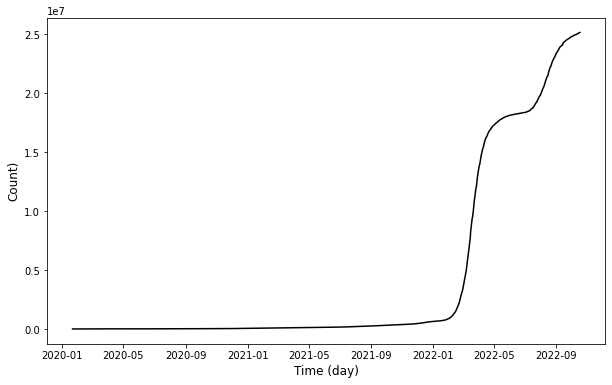

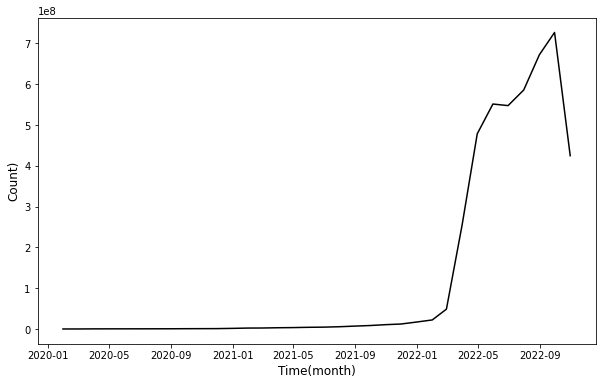

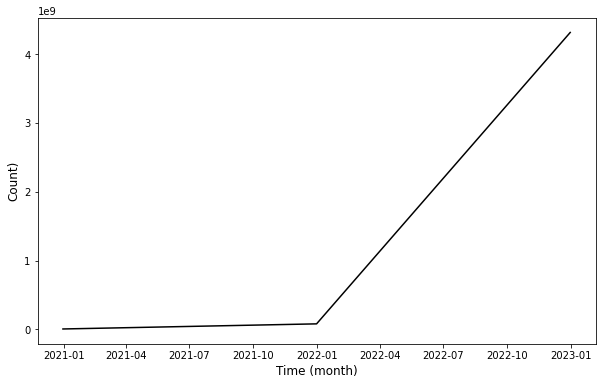

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel('Count)',
                                  {'fontsize': 12})
dataset = df.copy()
timeseries(df.index, dataset['Count'], 'Time (day)') #Time-series of daily water consumption
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['Count'],
           'Time(month)') # 월별 감염자 수
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['Count'],
           'Time (month)') #연간 감염자 수

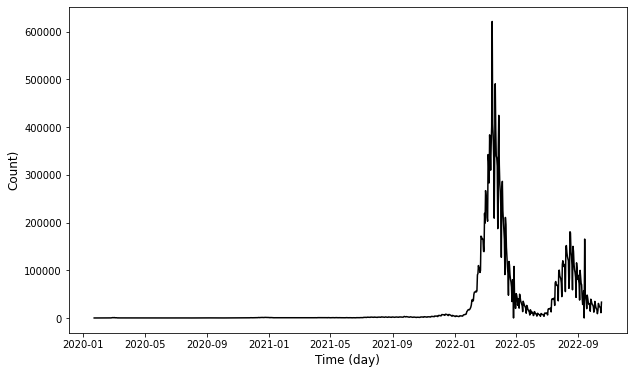

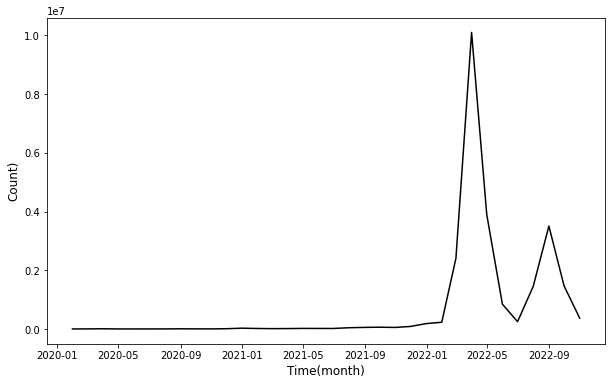

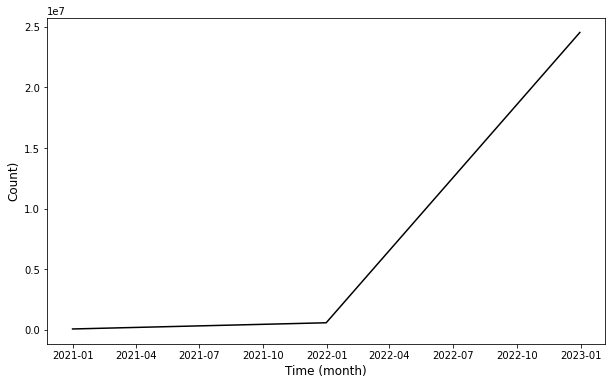

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel('Count)',
                                  {'fontsize': 12})
dataset = df1.copy()
timeseries(df1.index, dataset['Count'], 'Time (day)') #Time-series of daily water consumption
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['Count'],
           'Time(month)') # 월별 감염자 수
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['Count'],
           'Time (month)') #연간 감염자 수

# 모델적용

## GRU, BI-LSETM, MLP

### epoch 100 train_size 0.9

In [ ]:
--

In [ ]:
criteria = '2022-09-01'
#scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0

In [ ]:
# Split train data and test data
train_size = int(len(df1)*0.91)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]


In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
#LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (879, 30, 1)
y_train.shape:  (879, 1)
X_test.shape:  (60, 30, 1)
y_test.shape:  (60, 1)


In [ ]:
X_test[:33].shape

(33, 30, 1)

In [ ]:
# # Create  model
# def create_mlp(units):
#     model = Sequential()
#     model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(1))
#     model.compile(optimizer='adam',loss='mse')

#     return model
# model_mlp = create_mlp(64)

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0))
    # Hidden layer
    model.add(GRU(units = units) )
    model.add(Dropout(0))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   #model.add(Dense(256, activation='relu'))
    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

# Create  model
def create_mlp(units):
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse')

    return model
model_mlp = create_mlp(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)
history_mlp = fit_model(model_mlp)

Epoch 1/100
50/50 [==============================] - 13s 103ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 2/100
50/50 [==============================] - 3s 63ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 3/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 4/100
50/50 [==============================] - 4s 74ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 5/100
50/50 [==============================] - 3s 69ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 6/100
50/50 [==============================] - 3s 70ms/step - loss: 0.0018 - val_loss: 6.0981e-04
Epoch 7/100
50/50 [==============================] - 3s 51ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0018 - val_loss: 5.7730e-04
Epoch 9/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0012 - val_lo

In [ ]:


# Split train data and test data
train_size = int(len(df1)*0.91)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]

scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
#LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0))
    # Hidden layer
    model.add(GRU(units = units) )
    model.add(Dropout(0))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   #model.add(Dense(256, activation='relu'))
    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

# Create  model
def create_mlp(units):
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse')

    return model
model_mlp = create_mlp(64)



criteria = '2022-09-01'
#scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0


def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)
history_mlp = fit_model(model_mlp)

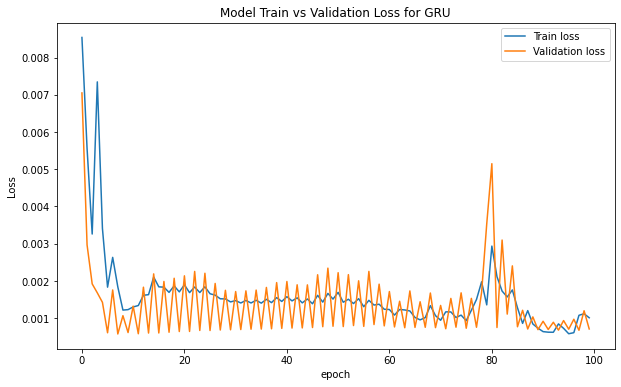

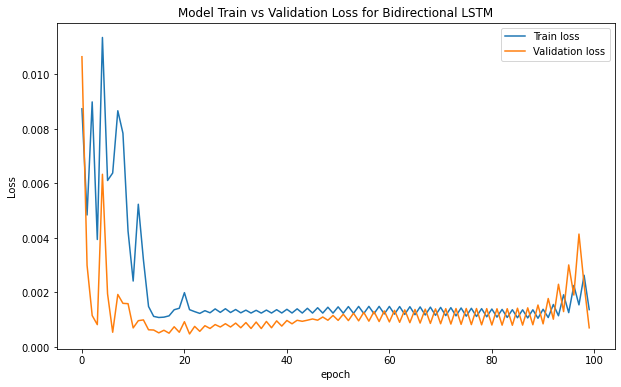

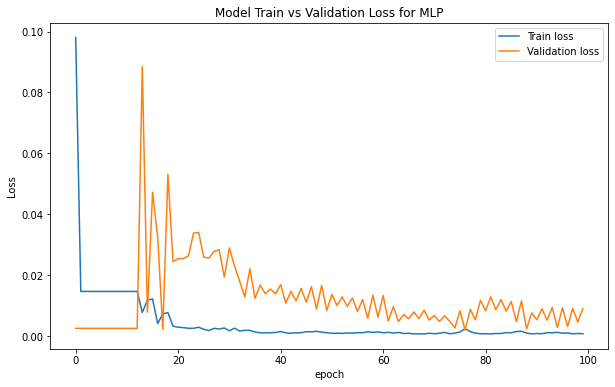

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')
plot_loss (history_mlp, 'MLP')

In [ ]:
# Transform data back to original data space

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

2/2 [==============================] - 0s 7ms/step


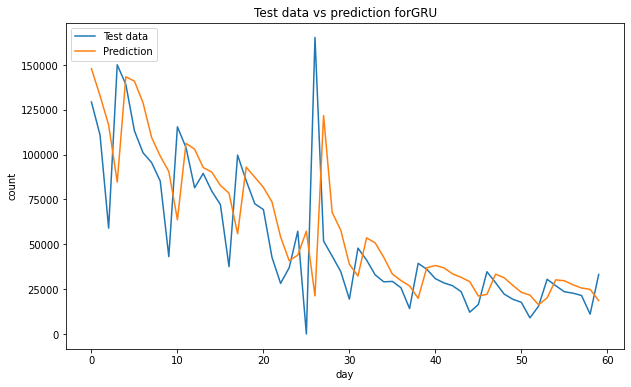

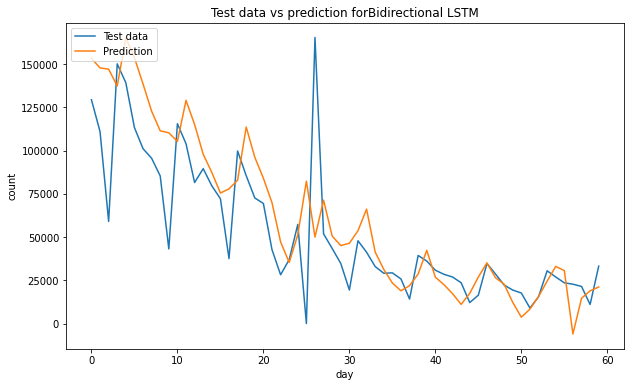

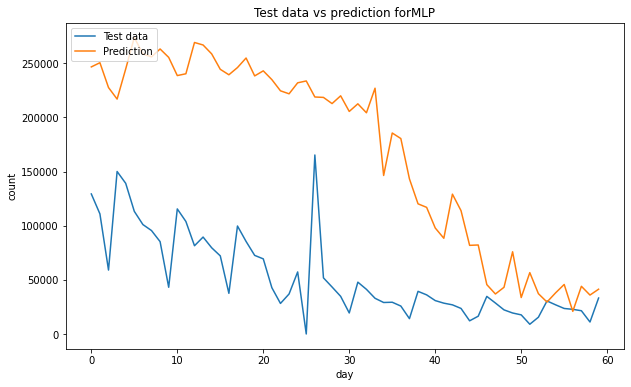

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
prediction_mlp = prediction(model_mlp)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for' + model_name)

    plt.legend(loc='upper left')
    plt.xlabel('day')
    plt.ylabel('count')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
plot_future(prediction_mlp, 'MLP', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')
evaluate_prediction(prediction_mlp, y_test, 'MLP')

GRU:
Mean Absolute Error: 19895.4344
Root Mean Square Error: 30399.5337

Bidirectiona LSTM:
Mean Absolute Error: 18979.9874
Root Mean Square Error: 28959.2930

MLP:
Mean Absolute Error: 116897.2146
Root Mean Square Error: 134932.7244



In [ ]:
# Select 60 days of data from test data
new_data = test_data.iloc[50:130]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape)

X_30.shape:  (10, 30, 1)


1/1 [==============================] - 0s 18ms/step


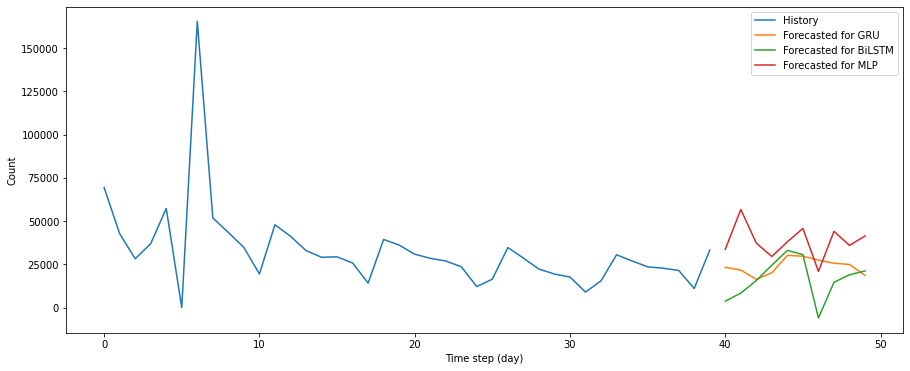

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
prediction_mlp = prediction(model_mlp)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2, prediction3):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')

    plt.plot(range_future, np.array(prediction1), label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for BiLSTM')
    plt.plot(range_future, np.array(prediction3), label='Forecasted for MLP')

    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Count')

plot_multi_step(new_data, prediction_gru, prediction_bilstm, prediction_mlp)

In [ ]:
df.diff(1)

,Count
Date,
2020-01-22,NaN
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,1.0
...,...
2022-10-13,23562.0
2022-10-14,22757.0
2022-10-15,21469.0


In [ ]:
new_data.tail(5)

,Count
Date,
2022-10-13,23562.0
2022-10-14,22757.0
2022-10-15,21469.0
2022-10-16,11040.0
2022-10-17,33190.0


In [ ]:
prediction_gru

array([[23239.322],
       [21680.156],
       [16307.684],
       [20131.24 ],
       [30171.094],
       [29698.807],
       [27423.357],
       [25631.682],
       [24888.75 ],
       [18594.654]], dtype=float32)

In [ ]:
prediction_bilstm

array([[ 3688.8022],
       [ 8357.295 ],
       [15627.1   ],
       [24512.553 ],
       [33045.18  ],
       [30611.791 ],
       [-6004.9995],
       [14602.132 ],
       [18938.223 ],
       [21153.4   ]], dtype=float32)

In [ ]:
prediction_mlp

array([[33659.49 ],
       [56676.008],
       [37226.074],
       [29501.033],
       [37996.785],
       [45733.113],
       [20900.72 ],
       [44043.01 ],
       [35949.715],
       [41351.43 ]], dtype=float32)

### EPOCH 200

In [ ]:
criteria = '2022-09-01'
#scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 200
verbose = 1
dropout_ratio = 0

In [ ]:
# Split train data and test data
train_size = int(len(df1)*0.91)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]


In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
#LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (879, 30, 1)
y_train.shape:  (879, 1)
X_test.shape:  (60, 30, 1)
y_test.shape:  (60, 1)


In [ ]:
X_test[:33].shape

(33, 30, 1)

In [ ]:
# # Create  model
# def create_mlp(units):
#     model = Sequential()
#     model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(Dense(1))
#     model.compile(optimizer='adam',loss='mse')

#     return model
# model_mlp = create_mlp(64)

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0))
    # Hidden layer
    model.add(GRU(units = units) )
    model.add(Dropout(0))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   #model.add(Dense(256, activation='relu'))
    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

# Create  model
def create_mlp(units):
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse')

    return model
model_mlp = create_mlp(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 200, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)
history_mlp = fit_model(model_mlp)

Epoch 1/200
50/50 [==============================] - 10s 73ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 2/200
50/50 [==============================] - 2s 34ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 3/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0090 - val_loss: 0.0017
Epoch 5/200
50/50 [==============================] - 2s 33ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 6/200
50/50 [==============================] - 3s 53ms/step - loss: 0.0019 - val_loss: 5.8956e-04
Epoch 7/200
50/50 [==============================] - 2s 33ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/200
50/50 [==============================] - 2s 33ms/step - loss: 0.0018 - val_loss: 5.8209e-04
Epoch 9/200
50/50 [==============================] - 2s 33ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/200
50/50 [==============================] - 2s 33ms/step - loss: 0.0016 - val_los

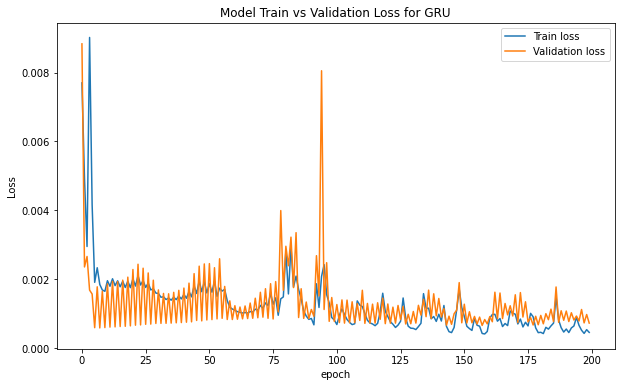

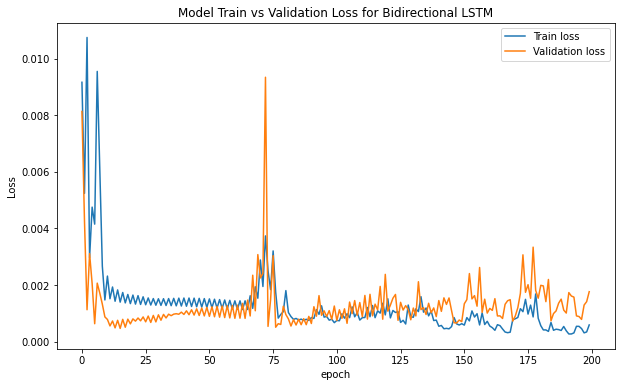

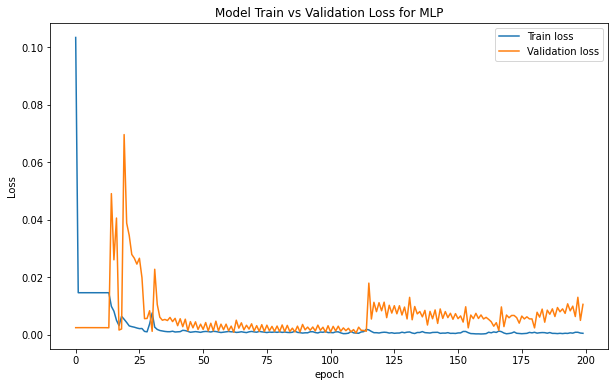

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')
plot_loss (history_mlp, 'MLP')

In [ ]:
# Transform data back to original data space

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

2/2 [==============================] - 0s 8ms/step


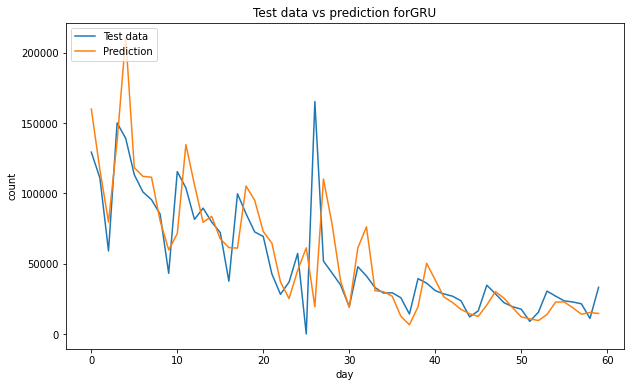

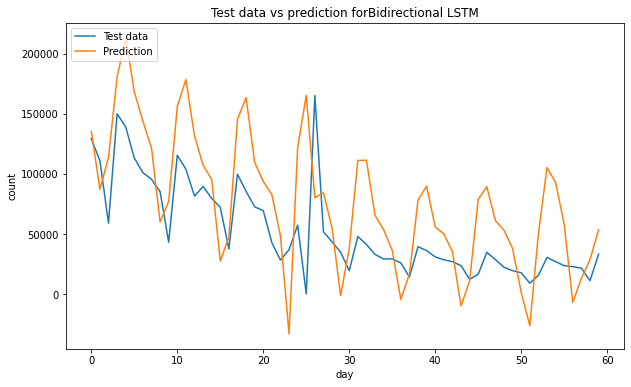

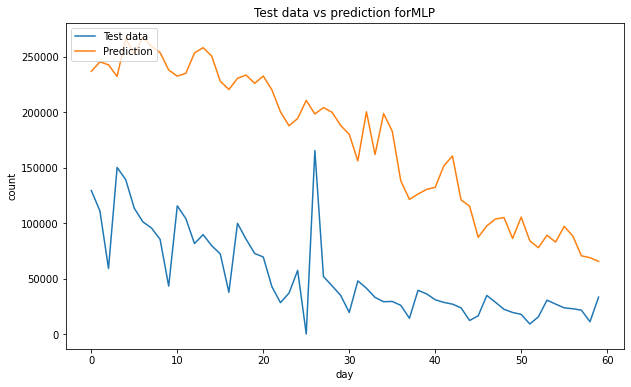

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
prediction_mlp = prediction(model_mlp)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for' + model_name)

    plt.legend(loc='upper left')
    plt.xlabel('day')
    plt.ylabel('count')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
plot_future(prediction_mlp, 'MLP', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')
evaluate_prediction(prediction_mlp, y_test, 'MLP')

GRU:
Mean Absolute Error: 16733.2421
Root Mean Square Error: 28277.5345

Bidirectiona LSTM:
Mean Absolute Error: 38413.6486
Root Mean Square Error: 46831.2407

MLP:
Mean Absolute Error: 121930.3198
Root Mean Square Error: 129850.9230



In [ ]:
# Select 60 days of data from test data
new_data = test_data.iloc[50:130]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape)

X_30.shape:  (10, 30, 1)


1/1 [==============================] - 0s 27ms/step


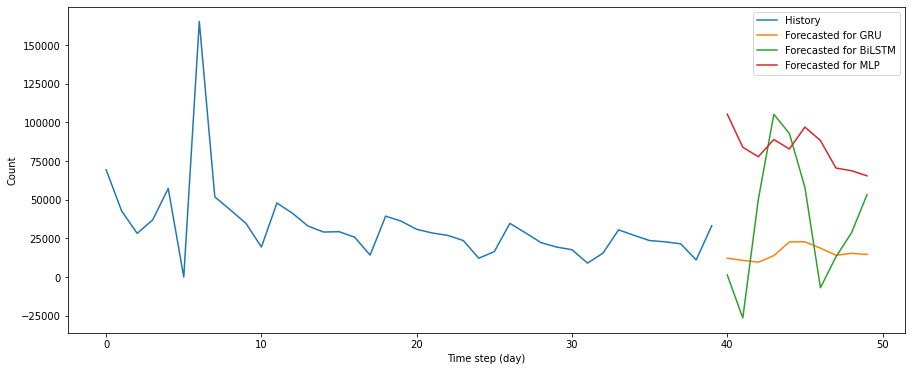

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
prediction_mlp = prediction(model_mlp)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2, prediction3):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')

    plt.plot(range_future, np.array(prediction1), label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for BiLSTM')
    plt.plot(range_future, np.array(prediction3), label='Forecasted for MLP')

    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Count')

plot_multi_step(new_data, prediction_gru, prediction_bilstm, prediction_mlp)

In [ ]:
df.diff(1)

,Count
Date,
2020-01-22,NaN
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,1.0
...,...
2022-10-13,23562.0
2022-10-14,22757.0
2022-10-15,21469.0


In [ ]:
new_data.tail(5)

,Count
Date,
2022-10-13,23562.0
2022-10-14,22757.0
2022-10-15,21469.0
2022-10-16,11040.0
2022-10-17,33190.0


In [ ]:
prediction_gru

array([[12161.253],
       [10759.446],
       [ 9564.472],
       [13845.364],
       [22706.16 ],
       [22794.535],
       [18650.527],
       [14066.764],
       [15292.688],
       [14591.577]], dtype=float32)

In [ ]:
prediction_bilstm

array([[  1323.0823],
       [-26516.502 ],
       [ 50180.77  ],
       [105267.95  ],
       [ 92875.37  ],
       [ 57983.97  ],
       [ -6953.313 ],
       [ 13068.917 ],
       [ 28546.348 ],
       [ 53313.004 ]], dtype=float32)

In [ ]:
prediction_mlp

array([[105367.85 ],
       [ 83939.69 ],
       [ 77812.36 ],
       [ 88956.08 ],
       [ 82834.04 ],
       [ 96979.83 ],
       [ 88291.35 ],
       [ 70477.68 ],
       [ 68760.72 ],
       [ 65436.453]], dtype=float32)

In [ ]:
--

### epoch 100 dense 추가

In [ ]:
#

In [ ]:
# Split train data and test data
train_size = int(len(df1)*0.9)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0))
    # Hidden layer
    model.add(GRU(units = units))
    model.add(Dropout(0))
    model.add(Dense(units = 128))
    model.add(Dense(units = 256))
    model.add(Dense(units = 128))
    model.add(Dense(units = 64))
    #model.add(Flatten())
    model.add(Dense(units = 0))
    #Compile model
    model.compile(optimizer='adam',loss='mse')

    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(128))
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Flatten())
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [ ]:
# Transform data back to original data space

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    #prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for' + model_name)

    plt.legend(loc='upper left')
    plt.xlabel('day')
    plt.ylabel('count')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

In [ ]:
# Select 60 days of data from test data
new_data = test_data.iloc[50:130]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape)

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')

    plt.plot(range_future, np.array(prediction1), label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for BiLSTM')

    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Count')

plot_multi_step(new_data, prediction_gru, prediction_bilstm)

In [ ]:
df1.tail(5)

In [ ]:
prediction_gru

In [ ]:
prediction_bilstm

In [ ]:
ASD

### epoch 200

In [ ]:
#tf.random.set_seed(1234)

In [ ]:
# Split train data and test data
train_size = int(len(df1)*0.91)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]


In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
#LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (879, 30, 1)
y_train.shape:  (879, 1)
X_test.shape:  (60, 30, 1)
y_test.shape:  (60, 1)


In [ ]:
X_test[:33].shape

(33, 30, 1)

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0))
    # Hidden layer
    model.add(GRU(units = units))
    model.add(Dropout(0))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')

    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 200, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/200
50/50 [==============================] - 7s 51ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 2/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 3/200
50/50 [==============================] - 2s 35ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/200
50/50 [==============================] - 3s 59ms/step - loss: 0.0091 - val_loss: 0.0014
Epoch 5/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 6/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0019 - val_loss: 5.5775e-04
Epoch 7/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/200
50/50 [==============================] - 2s 32ms/step - loss: 0.0013 - val_loss: 5.5810e-04
Epoch 9/200
50/50 [==============================] - 2s 36ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/200
50/50 [==============================] - 2s 33ms/step - loss: 0.0017 - val_loss

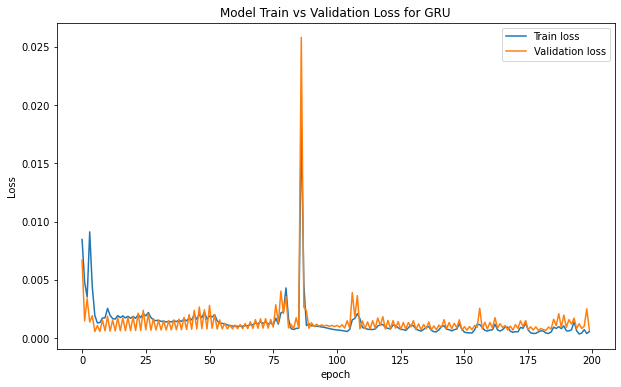

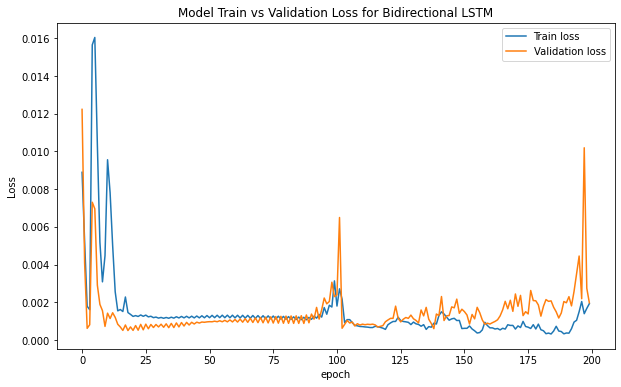

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [ ]:
# Transform data back to original data space

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

2/2 [==============================] - 2s 22ms/step


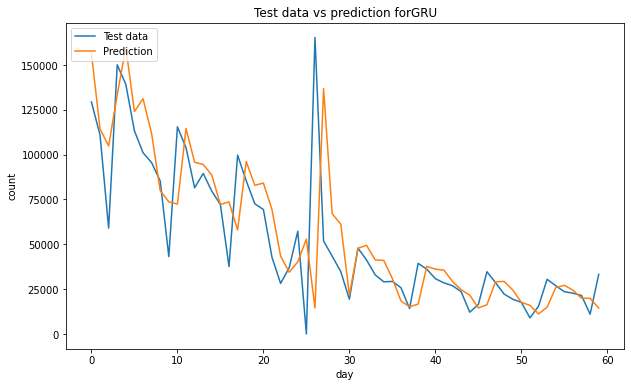

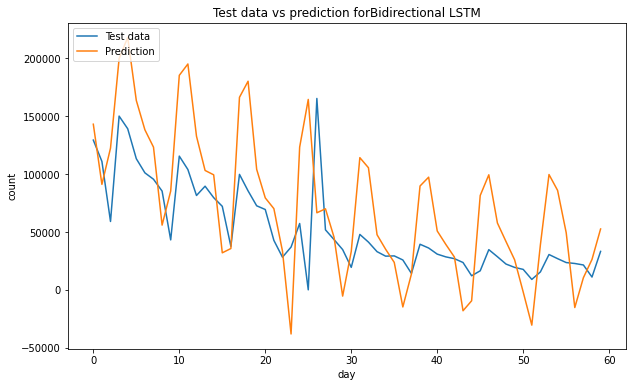

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for' + model_name)

    plt.legend(loc='upper left')
    plt.xlabel('day')
    plt.ylabel('count')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)
plot_future(prediction_MLP, '', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

GRU:
Mean Absolute Error: 16473.1483
Root Mean Square Error: 28593.2380

Bidirectiona LSTM:
Mean Absolute Error: 38725.6493
Root Mean Square Error: 49255.6116



In [ ]:
# Select 60 days of data from test data
new_data = test_data.iloc[50:130]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape)

X_30.shape:  (10, 30, 1)


1/1 [==============================] - 0s 34ms/step


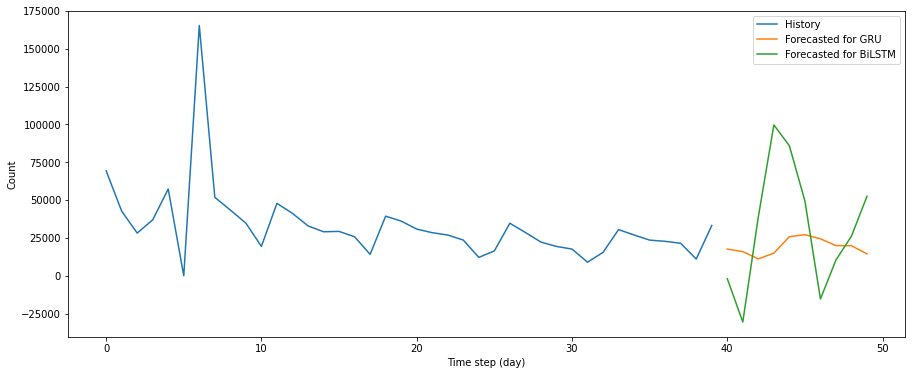

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')

    plt.plot(range_future, np.array(prediction1), label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for BiLSTM')

    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Count')

plot_multi_step(new_data, prediction_gru, prediction_bilstm)

In [ ]:
df.diff(1)

,Count
Date,
2020-01-22,NaN
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,1.0
...,...
2022-10-13,23562.0
2022-10-14,22757.0
2022-10-15,21469.0


In [ ]:
new_data.tail(5)

,Count
Date,
2022-10-13,23562.0
2022-10-14,22757.0
2022-10-15,21469.0
2022-10-16,11040.0
2022-10-17,33190.0


In [ ]:
prediction_gru

array([[17636.295],
       [15966.812],
       [11165.212],
       [14963.633],
       [25832.143],
       [27141.334],
       [24423.115],
       [19930.447],
       [19856.89 ],
       [14468.729]], dtype=float32)

In [ ]:
prediction_bilstm

array([[ -1893.7528],
       [-30504.14  ],
       [ 38948.797 ],
       [ 99609.81  ],
       [ 85895.76  ],
       [ 49362.67  ],
       [-15303.632 ],
       [ 10466.447 ],
       [ 26233.488 ],
       [ 52565.04  ]], dtype=float32)

In [ ]:
#
#model.add(SimpleRNN)
#model.add(RNN)
#model.add(MLP)

In [ ]:
-

SyntaxError: ignored

## mlp

### epoch 100

In [ ]:
criteria = '2022-09-01'
#scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 100
verbose = 1
dropout_ratio = 0

In [ ]:
# Split train data and test data
train_size = int(len(df1)*0.91)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]


In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
#LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

In [ ]:
# Create  model
def create_mlp(units):
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse')

    return model
model_mlp = create_mlp(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_mlp = fit_model(model_mlp)

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_mlp, 'MLP')
#plot_loss (history_bilstm, 'Bidirectional LSTM')

In [ ]:
# Transform data back to original data space

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_mlp = prediction(model_mlp)
#prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for' + model_name)

    plt.legend(loc='upper left')
    plt.xlabel('day')
    plt.ylabel('count')

plot_future(prediction_mlp, 'MLP', y_test)
#plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_mlp, y_test, 'MLP')
#evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

In [ ]:
# Select 60 days of data from test data
new_data = test_data.iloc[50:130]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape)

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_mlp = prediction(model_mlp)
#prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction3):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction3)))
    plt.plot(np.arange(range_history), np.array(history), label='History')

    plt.plot(range_future, np.array(prediction3), label='Forecasted for mlp')
    #plt.plot(range_future, np.array(prediction2), label='Forecasted for BiLSTM')

    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Count')

plot_multi_step(new_data, prediction_mlp)

In [ ]:
prediction_mlp

### epoch 200

In [ ]:
criteria = '2022-09-01'
#scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 200
verbose = 1
dropout_ratio = 0

In [ ]:
# Split train data and test data
train_size = int(len(df1)*0.91)

train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]


In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
#LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

In [ ]:
# Create GRU model
def create_mlp(units):
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse')

    return model
model_mlp = create_mlp(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1,
                    batch_size = 16, shuffle = False ) #callbacks = [early_stop]
    return history

history_mlp = fit_model(model_mlp)

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_mlp, 'MLP')
#plot_loss (history_bilstm, 'Bidirectional LSTM')

In [ ]:
# Transform data back to original data space

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_mlp = prediction(model_mlp)
#prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for' + model_name)

    plt.legend(loc='upper left')
    plt.xlabel('day')
    plt.ylabel('count')

plot_future(prediction_mlp, 'MLP', y_test)
#plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_mlp, y_test, 'MLP')
#evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

In [ ]:
# Select 60 days of data from test data
new_data = test_data.iloc[50:130]
# Scale the input
scaled_data = scaler.transform(new_data)
# Reshape the input
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape)

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_mlp = prediction(model_mlp)
#prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction3):

    plt.figure(figsize=(15, 6))

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction3)))
    plt.plot(np.arange(range_history), np.array(history), label='History')

    plt.plot(range_future, np.array(prediction3), label='Forecasted for mlp')
    #plt.plot(range_future, np.array(prediction2), label='Forecasted for BiLSTM')

    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Count')

plot_multi_step(new_data, prediction_mlp)

In [ ]:
prediction_mlp

In [ ]:
 #MLP
# Data Loading
# Data Loading
#location = 'C:/Users/82103/Desktop/개인공부\fast campus/파이썬을 활용한 시계열 데이터 분석 A-Z 올인원 패키지 Online/OnlineTSA-master/Data/Cryptocurrency/Bitcoin.csv'
#location = 'C:\Users\82103\Desktop\개인공부\fast campus\파이썬을 활용한 시계열 데이터 분석 A-Z 올인원 패키지 Online\OnlineTSA-master\Data\Cryptocurrency\Bitcoin.csv'

# location = '/content/drive/MyDrive/OnlineTSA-master/Data/Cryptocurrency/Bitcoin.csv' #위 drive mount를 통해 가능.
# raw_all = pd.read_csv(location, index_col='Date')
# raw_all.index = pd.to_datetime(raw_all.index)

df.index = pd.to_datetime(df.index)

# Parameters
criteria = '2021-05-01'
scaler = preprocessing.MinMaxScaler()
sequence = 60
batch_size = 32
epoch = 300
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = df1.loc[df1.index < criteria,:]
test = df1.loc[df1.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train,
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(),
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

# error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_test), graph_on=True)

In [ ]:
--

In [ ]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Count'] = min_max_scaler.fit_transform(df.Count.values.reshape(-1,1))
    # df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    # df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    # df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(count, seq_len):
    data_raw = [] # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# # choose one stock
df_count = df.copy()
# df_stock.drop(['symbol'],1,inplace=True)
# df_stock.drop(['volume'],1,inplace=True)

cols = list(df_count.columns.values)
print('df_count.columns.values = ', cols)

# normalize stock
df_count = df_count.copy()
df_count = normalize_data(df_count)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_count, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

In [ ]:
data

In [ ]:
--

--https://diane-space.tistory.com/331

# 모델적용
참고 : https://diane-space.tistory.com/331

In [ ]:
def ts_train_test(df, time_steps, for_periods):
    """
    input:
     data: dataframe with dates and price data
    output:
     X_train, y_train: data from 2013/1/1-2018-12/31
     X_test : data from 2019 -
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    """
    # create training and test set
    ts_train = df[:'2018'].iloc[:,0:1].values
    ts_test = df['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps, ts_train_len - 1):
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshapng X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

    # Preparing to creat X_test
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps, ts_test_len+ time_steps- for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    return X_train, y_train, X_test

X_train, y_train, X_test = ts_train_test(df,5,2)
X_train.shape[0], X_train.shape[1]

In [ ]:
--

In [ ]:
X=df.iloc[:,:]
y=df.iloc[:,:]
print(X)
print(y)

In [ ]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:700, :]
X_test = X_ss[700:, :]

y_train = y_ms[:700, :]
y_test = y_ms[700:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

In [ ]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input:
        data: dataframe with dates and price data
    output:
        X_train, y_train: data from 2013/1/1-2018/12/31
        X_test : data from 2019-
        sc :     insantiated MinMaxScaler object fit to the training data
    """
    # create training and test set
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train , X_test, sc

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 1
hidden_size = 3
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
df_x_ss = ss.transform(df.iloc[:, :])
df_y_ms = ms.transform(df.iloc[:, :])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

In [ ]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [ ]:
predicted

In [ ]:
--

In [ ]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        output, (hn, cn) = self.gru(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 1
hidden_size = 3
num_layers = 1

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
def train_model(model, optimizer, criterion, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=128, patience=100):
    model.train()
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

In [ ]:
# Training function
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=20, batch_size=128, patience=100):

    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss = []
    val_loss = []

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=20, batch_size=128, patience=100):

    # Convert NumPy arrays to PyTorch tensors
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to record losses

    loss_list = []
    val_loss_list = []

    best_val_loss = float('inf')
    early_stop_counter = 0

    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)

        # Append losses to the lists
        loss_list.append(loss.item())
        val_loss_list.append(val_loss.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Plot the training and validation losses
    plot_loss(loss_list, val_loss_list)